# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('../')

from mrcnn.config import Config
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mrcnn.shapes as shapes
from mrcnn.dataset import Dataset 

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")

# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
import tensorflow as tf
import keras
import pprint
import keras.backend as KB

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)

config = shapes.ShapesConfig()
config.BATCH_SIZE      = 2                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 2
config.STEPS_PER_EPOCH = 7
# config.IMAGES_PER_GPU  = 1

config.display() 


D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.4.0   Keras Version : 2.1.3 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE  

## Configurations

In [ ]:
# from keras import backend as KB
# if 'tensorflow' == KB.backend():
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     # tfconfig = tf.ConfigProto(
#         # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
#         # device_count = {'GPU': 1}
#     # )    
#     tfconfig = tf.ConfigProto()
#     tfconfig.gpu_options.allow_growth=True
#     tfconfig.gpu_options.visible_device_list = "0"
#     tfconfig.gpu_options.per_process_gpu_memory_fraction=0.5
#     tf_sess = tf.Session(config=tfconfig)
#     set_session(tf_sess)

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [2]:
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [3]:
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [3]:
# import importlib
# importlib.reload(model)
# Create model in training mode
# MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
import  gc
# del history
try :
    del model
except: 
    pass
 
gc.collect()

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180319T0843\mask_rcnn_shapes_{epoch:04d}.h5
 IMAGE SHAPE is : 128    128
<class 'list'>
Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_logits/concat:0
Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class/concat:0
Tensor("rpn_bbox/concat:0", shape=(?, ?, 4), dtype=float32) rpn_bbox/concat:0
Proposal Layer init complete. Size of anchors:  (4092, 4)
Tensor("proposal_targets/Shape_2:0", shape=(2,), dtype=int32)
Tensor("proposal_targets/Shape_4:0", shape=(2,), dtype=int32)
Shape of overlaps Tensor("proposal_targets/Shape_7:0", shape=(2,), dtype=int32)
Tensor("proposal_targets/Shape_9:0", shape=(2,), dtype=int32)
Tensor("proposal_targets/Shape_11:0", shape=(2,), dtype=int32)
Shape of overlaps Tensor("proposal_targets/Shape_14:0", shape=(2,), dtype=int32)
Tensor("proposal_targets/Shape_21:0", shape=(2,), dtype=int32)
Tensor("proposal_targets/Shape_23:0", shape=(2,), dtype=int32)

In [4]:
print(MODEL_PATH)
print(COCO_MODEL_PATH)
print(RESNET_MODEL_PATH)
print(MODEL_DIR)
print(model.find_last())

E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs
find_last info:   dir_name: E:\Models\mrcnn_logs\shapes20180313T1856
find_last info: checkpoint: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0215.h5
('E:\\Models\\mrcnn_logs\\shapes20180313T1856', 'E:\\Models\\mrcnn_logs\\shapes20180313T1856\\mask_rcnn_shapes_0215.h5')


In [5]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('Load weights complete')

find_last info:   dir_name: E:\Models\mrcnn_logs\shapes20180313T1856
find_last info: checkpoint: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0215.h5
load_weights:      from: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0215.h5
set_log_dir:  model_path (input) is : E:/Models/mrcnn_logs/shapes20180313T1856/mask_rcnn_shapes_0215.h5  
self.epoch set to 216  (Next epoch to run)
set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5
Load weights complete


In [ ]:
# for i in range(len(model.keras_model.layers)):
#     print(i, ' Name of layer: ', model.keras_model.layers[i].name)

In [ ]:
# sess = tf.InteractiveSession()
# model.keras_model.layers[229].output.eval()

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Training head using  Keras.model.fit_generator()

In [11]:
model.config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=69, 
            layers='heads')

KeyboardInterrupt: 

### Training heads using train_on_batch()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...



In [6]:

model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 5,
            layers='heads')

Last epoch completed : 216 
Starting from epoch 216 for 5 epochs. LR=0.001
Steps per epoch:   7 
Checkpoint Folder: E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5
Checkpoint folder already exists

Selecting layers to train
Layer    Layer Name               Layer Type
174  fpn_c5p5               (Conv2D)
176  fpn_c4p4               (Conv2D)
179  fpn_c3p3               (Conv2D)
182  fpn_c2p2               (Conv2D)
184  fpn_p5                 (Conv2D)
185  fpn_p2                 (Conv2D)
186  fpn_p3                 (Conv2D)
187  fpn_p4                 (Conv2D)
In model:  rpn_model
      1  rpn_conv_shared        (Conv2D)
      2  rpn_class_raw          (Conv2D)
      4  rpn_bbox_pred          (Conv2D)
199  mrcnn_mask_conv1       (TimeDistributed)
200  mrcnn_mask_bn1         (TimeDistributed)
202  mrcnn_mask_conv2       (TimeDistributed)
204  mrcnn_mask_bn2         (TimeDistributed)
205  mrcnn_class_conv1      (TimeDistributed)
207  mrcnn_class_bn1        (TimeDis

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/7 [===>..........................] - ETA: 1:52 - loss: 0.3904 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0523 Loading shapes obj mask infofor image_id :  388
 Shapes obj mask shape is : (128, 128, 3)
shape of mask is : (128, 128, 3)
after resize_mask shape is : (128, 128, 3)
after use_mini_mask  shape is : (56, 56, 3)
 Loading shapes obj mask infofor image_id :  288
 Shapes obj mask shape is : (128, 128, 1)
shape of mask is : (128, 128, 1)
after resize_mask shape is : (128, 128, 1)
after use_mini_mask  shape is : (56, 56, 1)
2/7 [=======>......................] - ETA: 47s - loss: 0.5607 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.3488 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.0726  Loading shapes obj mask infofor image_id :  449
 Shapes obj mask shape is : (128, 128, 3)
shape of mask is : (128, 128, 3)
after resize_mask shape is : (128, 128, 3)
after use_mini_mask  shape is


Epoch 00218: loss improved from 0.86686 to 0.56648, saving model to E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_0218.h5
Epoch 219/221
 Loading shapes obj mask infofor image_id :  92
 Shapes obj mask shape is : (128, 128, 1)
shape of mask is : (128, 128, 1)
after resize_mask shape is : (128, 128, 1)
after use_mini_mask  shape is : (56, 56, 1)
 Loading shapes obj mask infofor image_id :  411
 Shapes obj mask shape is : (128, 128, 3)
shape of mask is : (128, 128, 3)
after resize_mask shape is : (128, 128, 3)
after use_mini_mask  shape is : (56, 56, 3)
1/7 [===>..........................] - ETA: 2s - loss: 0.5448 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2376 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1626 Loading shapes obj mask infofor image_id :  395
 Shapes obj mask shape is : (128, 128, 2)
shape of mask is : (128, 128, 2)
after resize_mask shape is : (128, 128, 2)
after use_mini_mask  shape is : (56, 56, 2)
 Loading shapes obj mask infof

7/7 [==============================] - 2s 353ms/step - loss: 0.7064 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3483 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1872

Epoch 00220: loss did not improve
Epoch 221/221
 Loading shapes obj mask infofor image_id :  82
 Shapes obj mask shape is : (128, 128, 1)
shape of mask is : (128, 128, 1)
after resize_mask shape is : (128, 128, 1)
after use_mini_mask  shape is : (56, 56, 1)
 Loading shapes obj mask infofor image_id :  255
 Shapes obj mask shape is : (128, 128, 3)
shape of mask is : (128, 128, 3)
after resize_mask shape is : (128, 128, 3)
after use_mini_mask  shape is : (56, 56, 3)
1/7 [===>..........................] - ETA: 2s - loss: 1.3223 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.1874 - mrcnn_mask_loss: 0.6526 Loading shapes obj mask infofor image_id :  491
 Shapes obj mask shape is : (128, 128, 2)
shape of mask is : (128, 128, 2)
after resize_mask sha

#### Some network information 

In [7]:
from mrcnn.draft import show_modelstuff
model.compile(model.config.LEARNING_RATE, model.config.LEARNING_MOMENTUM)
show_modelstuff(model.keras_model)

 Learning phase value is:  1

 Metrics: 
[ 'loss',
  'rpn_class_loss',
  'rpn_bbox_loss',
  'mrcnn_class_loss',
  'mrcnn_bbox_loss',
  'mrcnn_mask_loss']

 Outputs: 
[ <tf.Tensor 'output_rois/mul:0' shape=(2, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class_logits/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'proposal_rois/packed_2:0' shape=(2, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class_logits/Reshape_1:0' shape=(?, 32, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class/Reshape_1:0' shape=(?, 32, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_bbox/Reshape:0' shape=(?, 32, 4, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_mask/Reshape_1:0' shape=(?, 32, 28, 28, 4) dtype=float32>,
  <tf.Tensor 'rpn_class_loss/cond/Merge:0' shape=() dtype=float32>,
  <tf.Tensor 'rpn_bbox_loss/cond/Merge:0' shape=() dtype=float32>,
  <tf.Tensor 'mrcnn_class_loss/truediv:0' shape=() dtype

In [265]:
# def get_layer_output(model, model_input,output_layer, training_flag = True):
#     _my_input = model_input 
#     for name,inp in zip(model.input_names, model_input):
#         print(' Input Name:  ({:24}) \t  Input shape: {}'.format(name, inp.shape))


#     _mrcnn_class = KB.function(model.input , model.output)
# #                               [model.keras_model.layers[output_layer].output])
#     output = _mrcnn_class(_my_input)                  
    
#     for name,out in zip (model.output_names,output):
#         print(' Output Name: ({:24}) \t Output shape: {}'.format(name, out.shape))
#     return output

In [399]:
from scipy.stats import  multivariate_normal
import numpy as np
def bbox_gaussian( bbox, Zin ):
    """
    receive a bounding box, and generate a gaussian distribution centered on the bounding box and with a 
    covariance matrix based on the width and height of the bounding box/. 
    Inputs : 
    --------
    bbox :  (index, class_id, class_prob, y1, x1, y2, x2)
    bbox :  (index, class_id, class_prob, cx, cy, width, height)
    Returns:
    --------
    bbox_g  grid mesh [image_height, image width] covering the distribution

    """
    print(bbox.shape)
    width  = bbox[6] - bbox[4]
    height = bbox[5] - bbox[3]
    cx     = bbox[4] + ( width  / 2.0)
    cy     = bbox[3] + ( height / 2.0)
#     cx, cy, width, height = bbox[3:]
    print('center is ({},{}) width: {}  height: {} '.format(cx, cy, width,  height))
#     srtd_cpb_2 = np.column_stack((srtd_cpb[:, 0:2], cx,cy, width, height ))
    X = np.arange(0, 128, 1)
    Y = np.arange(0, 128, 1)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape+(2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
    pos[:,:,0] = X;
    pos[:,:,1] = Y;

    rv = multivariate_normal([cx,cy],[[12,0.0] , [0.0,19]])
    Zout  = rv.pdf(pos)
    Zout += Zin
    return Zout

In [123]:
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_gaussian( Z ):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    X = np.arange(0, 128, 1)
    Y = np.arange(0, 128, 1)
    X, Y = np.meshgrid(X, Y)
    
    pos = np.empty(X.shape+(2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
    pos[:,:,0] = X;
    pos[:,:,1] = Y;
    surf = ax.plot_surface(X, Y, Z,cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    # # Customize the z axis.
    ax.set_zlim(0.0 , 0.05)
    ax.set_ylim(0,130)
    ax.set_xlim(0,130)
    ax.set_xlabel(' X axis')
    ax.set_ylabel(' Y axis')
    ax.invert_yaxis()
    ax.view_init(elev=140, azim=-88)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

In [ ]:
def stack_tensor(model):
    pred_cpb_all = np.empty((0,8))
    for i in range(1,model.config.NUM_CLASSES):
    if pred_cls_cnt[i] > 0:
        pred_cpb_all = np.vstack((pred_cpb_all, pred_cpb[i,0:pred_cls_cnt[i]] ))
    

In [10]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

# train_batch_x, train_batch_y = next(train_generator)

mm = model.keras_model

### Display shape loaded 

In [11]:
sample_x, sample_y = next(train_generator)

 Loading shapes obj mask infofor image_id :  282
 Shapes obj mask shape is : (128, 128, 3)
shape of mask is : (128, 128, 3)
after resize_mask shape is : (128, 128, 3)
after use_mini_mask  shape is : (56, 56, 3)
 Loading shapes obj mask infofor image_id :  244
 Shapes obj mask shape is : (128, 128, 1)
shape of mask is : (128, 128, 1)
after resize_mask shape is : (128, 128, 1)
after use_mini_mask  shape is : (56, 56, 1)


 Loading shapes obj mask infofor image_id :  245
 Shapes obj mask shape is : (128, 128, 2)
shape of mask is : (128, 128, 2)
after resize_mask shape is : (128, 128, 2)
after use_mini_mask  shape is : (56, 56, 2)
 Loading shapes obj mask infofor image_id :  479
 Shapes obj mask shape is : (128, 128, 3)
shape of mask is : (128, 128, 3)
after resize_mask shape is : (128, 128, 3)
after use_mini_mask  shape is : (56, 56, 3)
 image id is : [245 479]
 Loading shapes obj mask infofor image_id :  245
 Shapes obj mask shape is : (128, 128, 2)
(128, 128, 2) (2,)


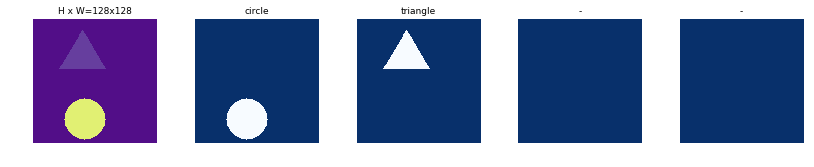

 image id is : [128 128]
 Loading shapes obj mask infofor image_id :  479
 Shapes obj mask shape is : (128, 128, 3)
(128, 128, 3) (3,)


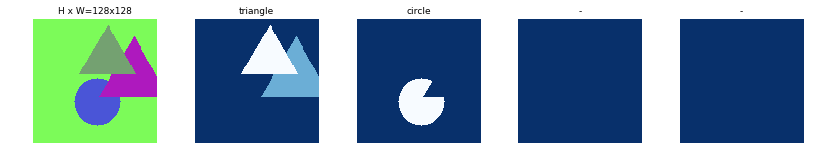

In [12]:
sample_x, sample_y = next(train_generator)

imgmeta_idx= mm.input_names.index('input_image_meta')
img_meta   =  sample_x[imgmeta_idx]
image_id   = img_meta[0,0]
print(' image id is :',img_meta[:,0])
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
print(mask.shape, class_ids.shape)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

print(' image id is :',img_meta[:,1])
image_id = img_meta[1,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
print(mask.shape, class_ids.shape)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [22]:
# mask_0 = mask[:,:,:]
# print(mask_0.shape)
# print(mask[:,:,0])
# print('\n\n\n')
# print(mask[:,:,1])
# print('\n\n\n')
# print(mask[:,:,2])
# print('\n\n\n')

from mrcnn.utils  import minimize_mask, extract_bboxes,resize_mask
import scipy    

# img = 1
# image_1 = sample_x[0][img]
# class_ids_1 = sample_x[4][img,0:objs].astype(int)
# bbox_1  = sample_x[5][img,0:objs]
# mask_1  = sample_x[6][img,:,:,0:objs]
# objs = np.count_nonzero(sample_x[4][img]) 
# print(class_ids_1, objs)

# print(objs)
# # mask_1  = minimize_mask(sampl,sample_x[6][0,:,:,0:objs],model.config.MINI_MASK_SHAPE)
# print(mask_1.shape, bbox_1.shape)

# print(mask_1[:,:,0])
# print('\n\n\n')
# print(mask_1[:,:,1])
# print('\n\n\n')
# print(mask_1[:,:,2])
# i  = 0

# mask is 128 x 128 x num_masks
# m = mask[:,:,1]
# m_str = np.array2string(m.astype('int'))
# print(m.shape, m.size)
# print(m_str)

# y1, x1, y2, x2 = bbox_1[0][:4]
# print(y1,':', y2, x1,':', x2, y2-y1, x2-x1 )
# mm = m[y1:y2, x1:x2]

# mask_1 is 56x56
# m1 = mask_1[:,:,0]
# m1_str = np.array2string(m1.astype('int'))
# print(m1.shape, m1.size)
# print(m1_str)



# m_str = np.array2string(m[0:50,:].astype(int))
# print(m.shape)
# print(m_str)
# print('\n\n\n')

# m2 = scipy.misc.imresize(m.astype(float), (56,56), interp='bilinear')
# m2_mask = np.where(m2 >= 128, 1, 0)
# m2_str = np.array2string(m2.astype('int'))
# print(m2.size)
# print(m2_str)

# mini_mask = np.zeros((56,56, objs), dtype=bool)
# mini_mask[:, :, i] = np.where(m2 >= 128, 1, 0)
# print(np.array2string(np.where(m >= 128, 1, 0)[:,:,0]))
# m[25:60,30:60]
# class_ids_1 = sample_x[4][0]

In [214]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))